# Vitber project - industrial mathematics
#### _Dimensionality reduction and noise removal of face images with Non-Negative Matrix Factorization_
_This code has been developed in DeepNote_

_Disclaimer: When working in deepnote we had the same 500 coice of images. When tranfering to jupyter notebook, this changed. If any of the numbers presented in the written text looks different than what is given by the code, this is the reason_



In this project the amount of data needed to describe a matrix will be reduced by using NMF (Non-negative Matrix Factorization). This means that a non-negative matrix A can be approximated as $$  A \approx A_{NMF} = WH$$, where $W$ and $H$ are two rectangular matrix. The purpose here is that the dimentions of the sum of $W$ and $H$ is smaller than for $A$. Notice that we accept an approximation of $A$ when multiplying $WH$. This approximation gives an error, which is desired as small as possible. 

First the NMF-algorithm will be implemented and tested for a couple of small matrices, where the error, $||A-WH||_F$, will be observed. Using the same methods pictures of faces will be compressed. Noise will be aplied to the faces, and then reduced with the help of NMF finding characteristic features and be able to find the avrage of these. The noisy images have a variation, and the issue of overfitting becomes relevant. This is discussed, and the dimention of the best fit four our factorization is found. 




##### Task 1 
a)The algoritm of the NMF assumes that $A$ has all non-negative elements. This is also the case for the matrices $W$ and $H$, which are updated in the following way:

$$ H_{k+1} = H_k \odot (W_k^T A) \oslash (W_k^T W_k H_k)$$

$$W_{k+1} = W_k \odot (A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$$

From this we can see that by the operations being used it is impossible to obtain any negative elements in the following iterates, as $\odot$ and $\oslash$ work element-wise. Essentially, we are summing, multiplying and deviding real positive numbers, which also returns real positive numbers. 

b)

We obtain our $W$ and $H$ matrices by finding the following minimum:

$\underset{W,H}{min} \: || A-WH ||_F$

Further, we know, from the introduction document, that the updated iterates $H_{k+1}$ and $W_{k+1}$ are weakly monotonically non-increasing, by satifying:
$||A - W_{k+1} H_{k+1}||  \leq || A - W_k H_k ||_F$, thus the action of element-wise multiplication with: $(W_k^T A) \oslash (W_k^T W_k H_k)$ and $(A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$ acts as a contraction for $W_k$ and $H_k$. These contraction mapping assure that we eventually will reach a point in our iteration where we have arrived at a fixed point corresponding to the contraction mapping. Thus for the case where $H_k$ is this fixed point, we know that $H_{k+1}$ is equal to $H_k$, and thus the operation $(W_k^T A) \oslash (W_k^T W_k H_k)$ is equal to a matrix of ones, denoted $\textbf{11}$. 
By substituting the expression $(W_k^T A) \oslash (W_k^T W_k H_k)$ with a matrix of ones we get:

$H_{k+1} = H_k \odot \textbf{11}$ - clearly showing $H_k$ is a fixed point.

With this in mind, we consider the case where $WH = A$. In our definition for obtaining $W$ and $H$ we see that in this case the value of: $\underset{W,H}{min} \: || A-WH ||_F$ is zero. And we know the F-norm to be non-negative, thus this is the true minimum, and $W$ and $H$ must be fixed points. 

c)

By initializing $H_0$ and $W_0$ as two matrices of only zeros, we quickly see that the iterations given by: $H_{k+1} = H_k \odot (W_k^T A) \oslash (W_k^T W_k H_k)$ and  $W_{k+1} = W_k \odot (A H_{k+1}^T) \oslash (W_k H_{k+1} H_{k+1}^T)$ yields nothing but further zero-matrices. So how does this hold up, considering that the Banach fixed point theorem states that the fixed point corresponding to the operations as mentioned in b yields a unique point? Does not the result above imply that the two zero-initialization also qualify as fixed points? Well perhaps, but this does not supply us with any solution to the factorization, as if  $W$ and $H$ are zero-matrices the expression $|| A-WH ||_F$ is actually equal to $||A||_F$, so not very close to zero. So the difficulty with having this as the initialization is that we get nowhere.


In the next two code blocks necessary libraries are installed and included.  

In [5]:
!pip install opencv-python
!pip install tabulate

In [6]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import cv2
import os
import time
from tabulate import tabulate
import scipy

Implementing the algorithm of the NMF is done as described in 1a), where the iteration is done max_it amount of times, before returning $W$, $H$, $A_{NMF}$, and an array containing $||A-WH||_F$ of all the iterations. It is then tested on some simple matrices.

In [7]:
#Defining the four matrces given in the assignment:
A1 = np.array([[1,0],[0,1]])
A2 = np.array([[1,2],[1,1], [1,2]])
A3 = np.array([[2,1,1],[2,1,1], [1,1,2]])
A4 = np.array([[2,1,0],[1,2,3], [0,3,3]])
np.random.seed(0)

#Setting max iterations: 
max_it = 1000


#1d) Implementing the NMF algorithm 1 described on page 10 in the assignment: 
def NMF(A, d, delta, tol):
    """
    Input: 
        A: mxn matrix
        d: number of components
        delta: safe division constant
        tol: tolerance
    Output:
        Returns W and H such that WH = A_nmf (approximate NMF factorization)
    """

    W_rows = np.size(A,0)
    H_cols = np.size(A,1)

    W_cols = d
    H_rows = d


    #Creating random matrix H0 and H0 and scaling them
    H0 = np.random.uniform(0, 1, size=(H_rows,H_cols)) * np.sqrt(np.mean(A)/d)
    W0 = np.random.uniform(0, 1, size=(W_rows,W_cols)) * np.sqrt(np.mean(A)/d)

    Hk = H0
    Wk = W0
    H = Hk
    norm_arr = np.zeros(max_it)
    for k in range(max_it):        
        H = np.divide(np.multiply(Hk, np.dot(Wk.transpose(), A)) ,np.dot(np.dot(Wk.transpose(),Wk),Hk)+delta)
        W = np.divide(np.multiply(Wk, np.dot(A, H.transpose())) ,np.dot(np.dot(Wk,H),H.transpose()) + delta)
        Hk = H
        Wk = W
        norm_arr[k] = np.linalg.norm(A-np.dot(W,H), 'fro')
    
    A_nmf = np.dot(W,H)

    return W, H, A_nmf, norm_arr


div_const = 10**(-9)
d = 1 
tol = 0.1


np.random.seed(0)
W1, H1, A_nmf1, fro_norm1 = NMF(A1, d, div_const, tol)
W3, H3, A_nmf3, fro_norm3 = NMF(A2, d, div_const, tol)

np.random.seed(5)
W2, H2, A_nmf2, fro_norm2 = NMF(A1, d, div_const, 0.1)
W4, H4, A_nmf4 , fro_norm4= NMF(A2, d, div_const, 0.1)

table = [[ "d",'Start matrix',"", 'W', 'H', "WH", "||A-WH||_F"], 
        [d,"A1:",A1, W1, H1, np.dot(W1,H1), np.linalg.norm(A1-np.dot(W1,H1), 'fro')], 
        [d,"A1:",A1, W2, H2, np.dot(W2,H2), np.linalg.norm(A1-np.dot(W2,H2), 'fro')],
        [d,"A2:",A2, W3, H3, np.dot(W3,H3), np.linalg.norm(A2-np.dot(W3,H3), 'fro')], 
        [d,"A2:",A2, W4, H4, np.dot(W4,H4), np.linalg.norm(A2-np.dot(W4,H4), 'fro')]
        ]
    
print(tabulate(table))



-  ------------  -------  --------------  -------------------------  -------------------------  -------------------
d  Start matrix           W               H                          WH                         ||A-WH||_F
1  A1:           [[1 0]   [[0.42621884]   [[1.29113491 1.16715364]]  [[0.55030602 0.49746287]   1.0
                  [0 1]]   [0.38529116]]                              [0.49746287 0.44969398]]
1  A1:           [[1 0]   [[0.1461716 ]   [[0.32974238 1.46530818]]  [[0.04819897 0.21418644]   1.0
                  [0 1]]   [0.64955689]]                              [0.21418644 0.95180103]]
1  A2:           [[1 2]   [[1.13499938]   [[0.96937943 1.71210862]]  [[1.10024505 1.94324222]   0.41115460006510884
                  [1 1]    [0.69270975]                               [0.67149858 1.18599434]
                  [1 2]]   [1.13499938]]                              [1.10024505 1.94324222]]
1  A2:           [[1 2]   [[0.78950253]   [[1.3935928 2.4613502]]    [[1.10024505 

In the table above the matrices involved in the Non-Negative Matrix Factorization of $A_1$ and  $A_2$ is printed. It is noticable that there is a difference in $A$ and $WH$. Still we see that the Frobenius norm of the difference is under 1. We also notice that the difference is smaller for A2, which is a larger matrix. It is also noticable that this length is independent of the startvalues of $W$ and $H$, since the product $WH$ is the same for both solutions. We also see that the start values for $W$ and $H$ give the same Frobenius norm.

Next, the algorithm is run for $d = 2$:

In [8]:
#1e) 
div_const = 10**(-9)
d = 2
tol = 0.1


np.random.seed(0)
W1, H1, A_nmf1, fro_norm1 = NMF(A1, d, div_const, tol)
W3, H3, A_nmf3, fro_norm3 = NMF(A2, d, div_const, tol)

np.random.seed(5)
W2, H2, A_nmf2, fro_norm2 = NMF(A1, d, div_const, 0.1)
W4, H4, A_nmf4 , fro_norm4= NMF(A2, d, div_const, 0.1)

table = [[ "d",'Start matrix', 'W', 'H', "WH", "||A-WH||_F"], 
        [d, A1, W1, H1, np.dot(W1,H1), np.linalg.norm(A1-np.dot(W1,H1), 'fro')], 
        [d, A1, W2, H2, np.dot(W2,H2), np.linalg.norm(A1-np.dot(W2,H2), 'fro')],
        [d, A2, W3, H3, np.dot(W3,H3), np.linalg.norm(A2-np.dot(W3,H3), 'fro')], 
        [d, A2, W4, H4, np.dot(W4,H4), np.linalg.norm(A2-np.dot(W4,H4), 'fro')]
        ]
    
print(tabulate(table))

-  ------------  -------------------------  -------------------------  -------------------------  ----------------------
d  Start matrix  W                          H                          WH                         ||A-WH||_F
2  [[1 0]        [[0.49431984 0.        ]   [[2.0229817  0.        ]   [[1. 0.]                   8.62997919896208e-10
    [0 1]]        [0.         0.70739897]]   [0.         1.41362942]]   [0. 1.]]
2  [[1 0]        [[0.         0.59361639]   [[0.         1.58418288]   [[1. 0.]                   8.665129534594813e-10
    [0 1]]        [0.63124025 0.        ]]   [1.6845896  0.        ]]   [0. 1.]]
2  [[1 2]        [[0.07915089 0.8290034 ]   [[1.36235721 0.97354665]   [[1.00000001 1.99999999]   1.9499545553292463e-08
    [1 1]         [0.58862132 0.18406305]    [1.07619369 2.31958388]]   [1.         1.        ]
    [1 2]]        [0.07915086 0.82900342]]                              [0.99999999 2.00000001]]
2  [[1 2]        [[0.49837486 0.29550198]   [[1.7296530

Here we can see that $||A_1 - WH||_F$ is very close to zero with a value of approximately $8.63\cdot10^{-10}$. $WH$ is apparantly equivalent to the start matrix for both $A_1$ and $A_2$. The rank of the matrices are 2 for both $A_1$ and $A_2$, where $d = 2$ makes it possible to represent the data properly. The results are therefore very reasonable. The ranks are calculated below.

In [9]:
#1f

def getRank(M):
    i=0
    eigs = la.svd(M)[1] #Finding singular values instead of eigenvalues enables this computation for non-square matrices.
    for el in eigs:
        if(el != 0):
            i += 1
    return i

print('The ranks of A1 and A2 is', getRank(A1), 'and', getRank(A2), "with the getRank method")
print('The ranks of A3 and A4 is', getRank(A3), 'and', getRank(A4), "with the getRank method")
print('The ranks of A3 and A4 is', la.matrix_rank(A3), 'and', la.matrix_rank(A4), 'with the numpy linalg method')

The ranks of A1 and A2 is 2 and 2 with the getRank method
The ranks of A3 and A4 is 3 and 3 with the getRank method
The ranks of A3 and A4 is 2 and 3 with the numpy linalg method


The code-block above contains a simple mathod of determening the rank of any given matrix. Initially it counted the number of non-zero eigenvalues, but the relization that this would not work for non-square matrices made us switch to singular values instead. Singular values of a matrix $A$ are attained by solutions to the characteristic equation/polynomial of the matrix $AA^T$, which can be computed for any matrix. And since the number of non-zero singular values also corresponds to the rank of the matrix this is a great way of determening the rank. However, this method proved to have a shortfall. It does not work very well with the floating point datatype, and results in wrong answers where a singular value should be zero, but is instead just extremly small. So we use the numpy linalg "matrix_rank" instead. 

In the code underneath the evolution of the error as a fuction of iteration will be plotted before analysing them. 

Error after last iteration for A3: 
 	 d = 1:  1.14841379830242 ,
 	 d = 2:  1.0291827411054609e-09 ,
 	 d = 3:  1.242030709743448e-09


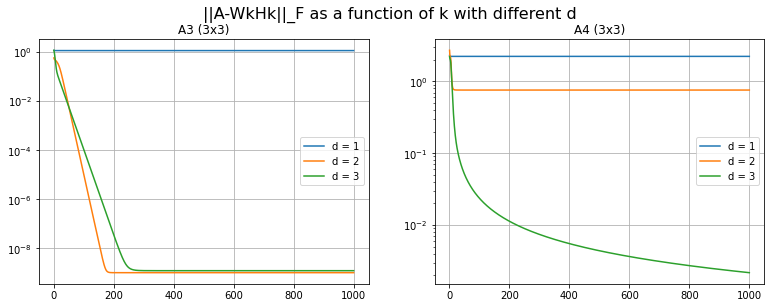

In [10]:
#1g
np.random.seed(0)

d = 1
W1, H1, A_nmf1, fro_norm1 = NMF(A3, d, div_const, tol)
W2, H2, A_nmf2, fro_norm2 = NMF(A4, d, div_const, tol)
d = 2
W1, H3, A_nmf3, fro_norm3 = NMF(A3, d, div_const, tol)
W4, H4, A_nmf4, fro_norm4 = NMF(A4, d, div_const, tol)
d = 3
W5, H5, A_nmf5, fro_norm5 = NMF(A3, d, div_const, tol)
W6, H6, A_nmf6, fro_norm6 = NMF(A4, d, div_const, tol)

x = list(range(1, max_it+1))


fig, ax = plt.subplots(1, 2)
fig.set_figheight(4.5)
fig.set_figwidth(13)
fig.suptitle("||A-WkHk||_F as a function of k with different d", size = 16)
ax[0].set_title("A3 (3x3)")
ax[0].semilogy(x, fro_norm1, label = "d = 1")
ax[0].semilogy(x, fro_norm3, label = "d = 2")
ax[0].semilogy(x, fro_norm5, label = "d = 3")
ax[0].legend(loc = 'center right')
ax[0].grid()

ax[1].set_title("A4 (3x3)")
ax[1].semilogy(x, fro_norm2, label = "d = 1")
ax[1].semilogy(x, fro_norm4, label = "d = 2")
ax[1].semilogy(x, fro_norm6, label = "d = 3")
ax[1].legend(loc = 'center right')
ax[1].grid()

print("Error after last iteration for A3: \n \t d = 1: ", fro_norm1[-1], ",\n \t d = 2: ", fro_norm3[-1],",\n \t d = 3: ", fro_norm5[-1])


The size of $d$ is such that a larger $d$ converges closer to zero. For $A_3$, the error is smaller for $d=2$ than for $d=3$. Keeping in mind that the $rank(A_3) = 2$, the presision does not get better for a larger $d$ in this case. When looking at the plots one can see that $||A-W_kH_k||_F$ decreases or stays the same as $k$ increases. We can therefor assume that equation (17) on page 9 is satisfied. This can  be checked using a simple _for_ and _if_ loop:

In [ ]:
for i in range(len(fro_norm1)-1):
    if (fro_norm1[i+2] > fro_norm1[i+1]):
        diff = fro_norm1[i+2] - fro_norm1[i+1]
        print ("A3 (d=1):", ": Not satisfied at", i, ", with differance", diff)
        break
for i in range(len(fro_norm3)-1):
    if (fro_norm3[i+2] > fro_norm3[i+1]):
        diff = fro_norm3[i+2] - fro_norm3[i+1]
        print ("A3 (d=2):",  ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm5)-1):
    if (fro_norm5[i+2] > fro_norm5[i+1]):
        diff = fro_norm5[i+2] - fro_norm5[i+1]
        print ("A3 (d=3):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm2)-2):
    if (fro_norm2[i+2] > fro_norm2[i+1]):
        diff = fro_norm2[i+2] - fro_norm2[i+1]
        print ("A4 (d=1):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm4)-2):
    if (fro_norm4[i+2] > fro_norm4[i+1]):
        diff = fro_norm4[i+2] - fro_norm4[i+1]
        print ("A4 (d=2):", ": Not satisfied at", i,", with differance", diff)
        break
for i in range(len(fro_norm6)-2):
    if (fro_norm6[i+2] > fro_norm6[i+1]):
        diff = fro_norm6[i+2] - fro_norm6[i+1]
        print ("A4 (d=3):", ": Not satisfied at", i,", with differance", diff)
        break



A3 (d=1): : Not satisfied at 6 , with differance 2.220446049250313e-16
A3 (d=2): : Not satisfied at 239 , with differance 3.193213171036889e-16
A3 (d=3): : Not satisfied at 402 , with differance 2.476374233577311e-17
A4 (d=1): : Not satisfied at 11 , with differance 4.440892098500626e-16
A4 (d=2): : Not satisfied at 187 , with differance 2.220446049250313e-16


We observe that there are some exeptions to equation (17), but seeing that the error is powered to the -16th, there is reason to believe that this is due floating point error, and that the equation is in practice satisfied, as observed in the plot above.

The next step is to start woriking with the images. First of all the images are loaded from a cryptopunk dataset and return $N$ faces. This is done by the function _load_images_. _plotimgs_ does as it says, and plots the faces.

In [ ]:
#2a

def load_images(N):
    """
    Loads images from cryptopunk dataset. The loading order is deterministic,
    so for a certain N the exact same images will be loaded. 
    Input:
        N, integer, number of images to load
    Output:
        faces, (24,24,4,N) numpy array containing images
    """

    # Allocate array to store images
    faces = np.zeros((24,24,4,N))

    # Iteration variable
    i = 0

    # Iterate over folders
    for subdir, dirs, files in os.walk('./imgs'):

        # Iterate over files
        for file in files:

            # Filepath to load from
            filepath = subdir + os.sep + file

            # Make sure that the file is a .png
            if filepath[-3:] == 'png':

                # Load the image
                im = cv2.imread(filepath, cv2.IMREAD_UNCHANGED)

                # Convert it to RGBA and rescale pixels
                faces[:,:,:,i] = cv2.cvtColor(im, cv2.COLOR_BGRA2RGBA)/255.0

                i+=1
            if i == N:
                break
    return faces

# Number of faces to keep in final array
N = 500

# Load all 10000 images
faces = load_images(10000)

# Select N random images
choices = np.random.choice(faces.shape[-1],N, replace = False)
faces = faces[:,:,:,choices]

# Check that the shape is correct
print(faces.shape)

(24, 24, 4, 500)


In [ ]:
#2a
# Code for plotting images
def plotimgs(imgs, nplot = 8, rescale = False, filename = None):
    """
    Plots nplot*nplot images on an nplot x nplot grid. 
    Saves to given filename if filename is given
    Can also rescale the RGB channels
    input:
        imgs: (24,24,4,N) or (24,24,3,N) array containing images, where N > nplot**2
        nplot: integer, nplot**2 images will be plotted
        rescale: bool
        filename: string, figure will be saved to this location. Should end with ".png".
    """
    # We will change some of the parameters of matplotlib, so we store the initial ones
    oldparams = plt.rcParams['figure.figsize']

    # New params to make better plot. There definitely exists better ways of doing this
    plt.rcParams['figure.figsize'] = (16, 16)

    # Initialize subplots
    fig, axes = plt.subplots(nplot,nplot)

    # Set background color
    plt.gcf().set_facecolor("lightgray")

    # Iterate over images
    for idx in range(nplot**2):
        
        # Indices
        i = idx//nplot; j = idx%nplot

        # Remove axis
        axes[i,j].axis('off')

        # Rescale RGB channels by dividing my maximal value
        if rescale:
            scaled_img = np.copy(imgs[:,:,:,idx])
            scaled_img[:,:,:3] = scaled_img[:,:,:3]/np.max(scaled_img[:,:,:3])
            axes[i,j].imshow(scaled_img)
        else:
            axes[i,j].imshow(imgs[:,:,:,idx])

    # Tight layout so images will appear closer together
    plt.tight_layout()

    # Save if filename is given
    if filename is not None:
        plt.savefig(filename)

    plt.show()

    # Return to old parameters
    plt.rcParams['figure.figsize'] = oldparams

#2a

The two code-blocks above are simply the supplied code for this assignment. The data set we end up with consists of a mesh of 24*24 pixels, with 4 channels, 3 for color, RGB (Red, Green , Blue) which contain a numerical value, on the interval (0,255) traditionaly but here represented with a number between 0 and 1, corresponding to "the amount" of red, green and blue light that the pixel asserts. The fourth channel is opacity, which we sort of leave out of our calculations, as we assume it is known. Lastly there we have chosen 500 out of the 10,000 images supplied. Thus the data set we work with is a 4d-array with the shape (24,24,4,500), although as we do calculations and reshape this set, we are more often working with a shape (24,24,3,500), where the opacity-values in the third axis are removed. 

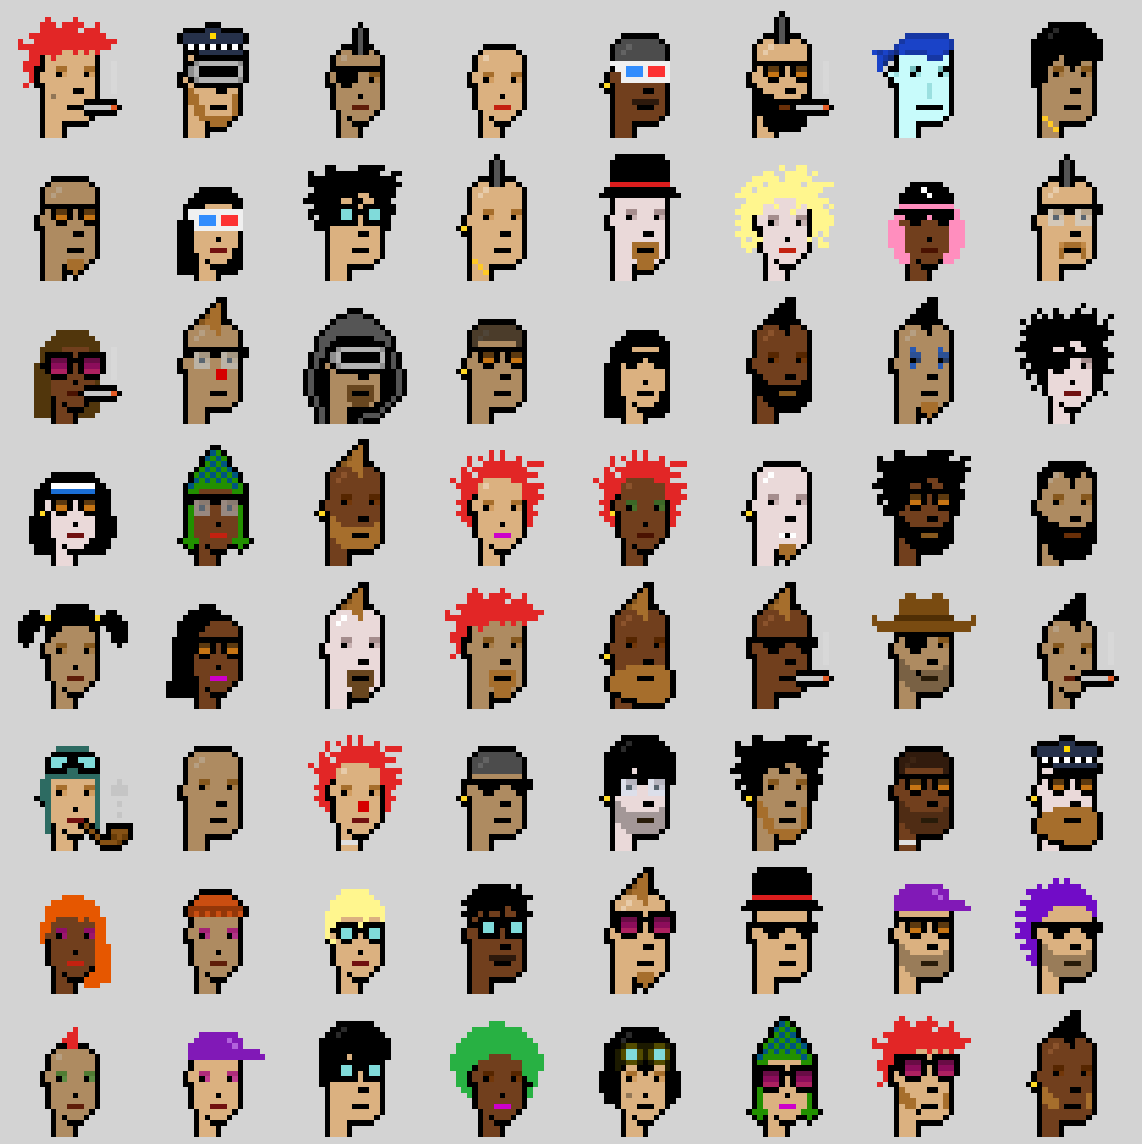

In [ ]:
#2a
# Example of plotting 8 times 8 images stored in "faces" and saving the output to a file named "punks.png"
plotimgs(faces, 8, filename="punks.png")

The specific value of one of the dark purple pixels in the average opacity plot is: [0. 0. 0. 0.] telling us that there are some pixels, and more importantly rows and/or columns of pixels that all have value 0
Rank of the matrix containing opacity values:  21


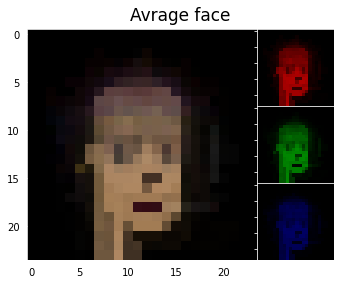

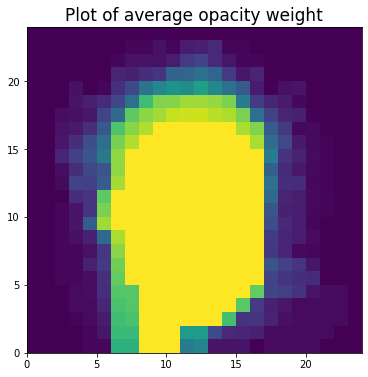

In [ ]:
#2b
from mpl_toolkits.axes_grid1.axes_rgb import RGBAxes

colorChannelMeans = np.mean(faces,axis=-1)


fig = plt.figure()
fig.suptitle("Avrage face", size = 17)
ax = RGBAxes(fig, [0.1, 0.1, 0.8, 0.8])
ax.imshow_rgb(colorChannelMeans[:,:,0],colorChannelMeans[:,:,1],colorChannelMeans[:,:,2],interpolation='none')




fig, axs = plt.subplots(1, 1, figsize = (6, 6))
axs.pcolormesh(np.fliplr(np.flip(colorChannelMeans[:,:,3])))
axs.set_title(f'Plot of average opacity weight', size = 17)

corner = colorChannelMeans[:,:,:][0][0]
print("The specific value of one of the dark purple pixels in the average opacity plot is:", corner, 
"telling us that there are some pixels, and more importantly rows and/or columns of pixels that all have value 0")


print("Rank of the matrix containing opacity values: ",getRank(colorChannelMeans[:,:,3]))

The plot above show the average RGB and opacity values for the pixels taken across all pictures. A plot like this, or more specifically the values that this plot reprecent can provide valuable information about where in the datastructure the commonalities lie, and thereby help us in the process of simplifying it. The dark purple squares in the second plot show us that there are pixels that always have $[0,0,0,0]$ as their color chanel vector. The last plot represents the average opacity, and as we see by the dark purple color, there are many instances of pixels having the value 0 across all images. From the first plot we also see that there are many pixels that hold no RGB values. Thus, some of the pixels are barren of data, and this may affect the rank of the data matrix.



For the full array containing all the faces we can determine the rank with the numpy linalg rank-function. As we see bellow, the rank of the matrix containing the information of 500 images is equal to 393. We found it a bit hard to find an excact explanation of why we get this number, and what it corresponds to in the underlying data structure. If we imagine that we had 500 images that did not differ in any way, then when we could reduce the whole matrix to a single row, and all other elements would be zero. From there, when determaning the rank, we would get 1, since such a matrix would only have 1 eigenvalue. In the light of this, the value for the rank that we got suggests that there are faces of the 500 selected, that can be fully described by other faces' traits. So in a case where all images had a unique feature that no ther image in the set has, then the rank of the metrix would be 500.

In [ ]:
rank_faces = faces.reshape(24*24*4,500)
print('The rank of the full matrix containing 500 faces is',la.matrix_rank(rank_faces))


The rank of the full matrix containing 500 faces is 393


In [ ]:
#2c

faces_rgb = faces[:,:,:3,:]
shape = faces_rgb.shape
faces_reshaped = faces_rgb.reshape(np.prod(shape)//N, N)


d = 64

x_1 = NMF(faces_reshaped, d, div_const, tol)
W = x_1[0]
H = x_1[1]


d = 192

x_2 = NMF(faces_reshaped, d, div_const, tol)
W_2 = x_2[0]
H_2 = x_2[1]

d = 500

x_3 = NMF(faces_reshaped, d, div_const, tol)
W_3 = x_3[0]
H_3 = x_3[1]

In [ ]:


W_reshaped = W.reshape(24, 24, 3, 64)
W2_reshaped = W_2.reshape(24, 24, 3,192)
W3_reshaped = W_3.reshape(24, 24, 3,500)




Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

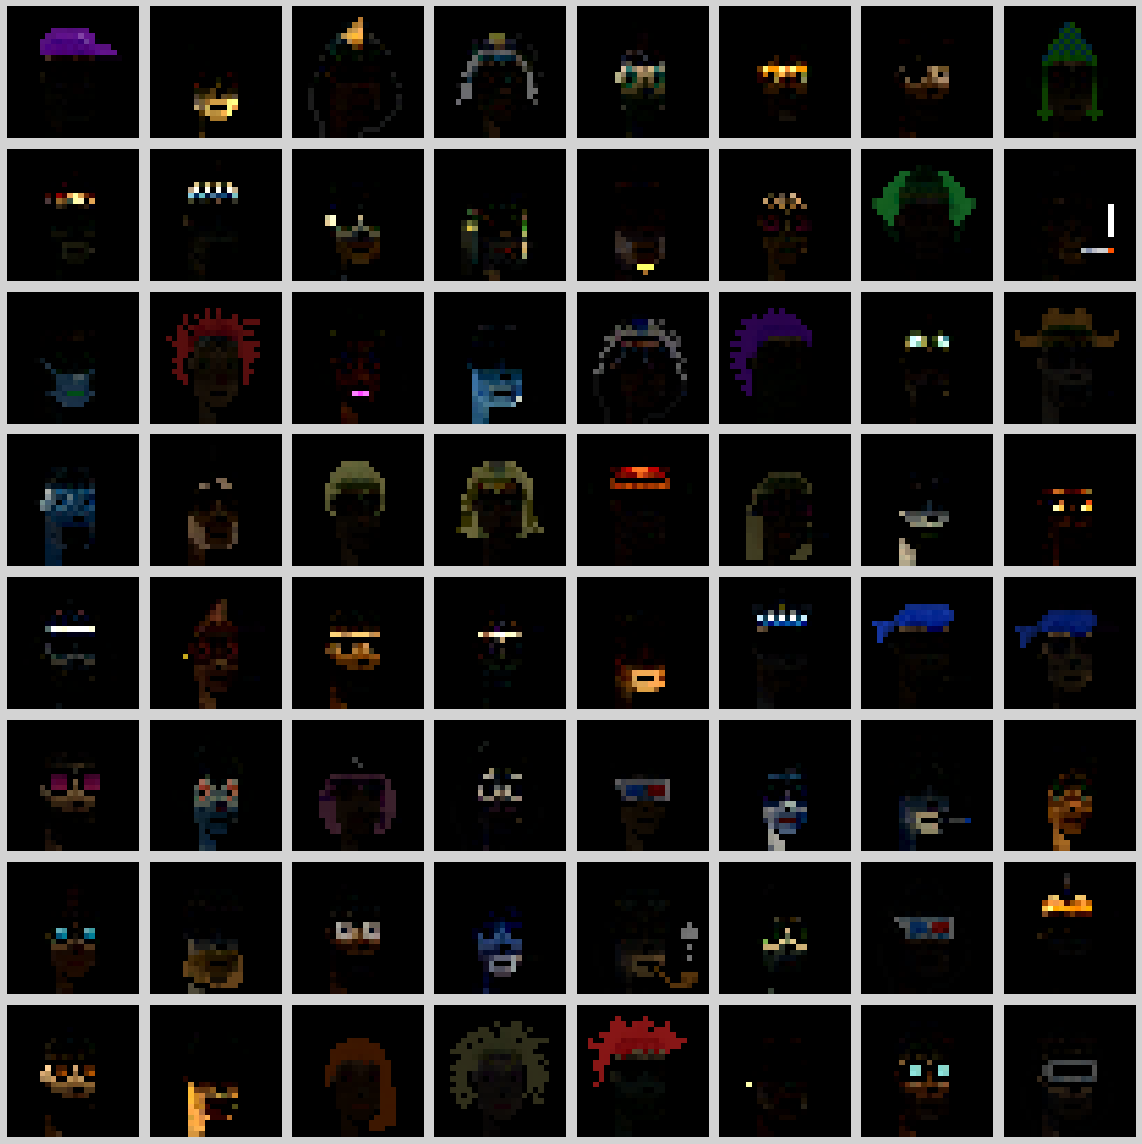

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

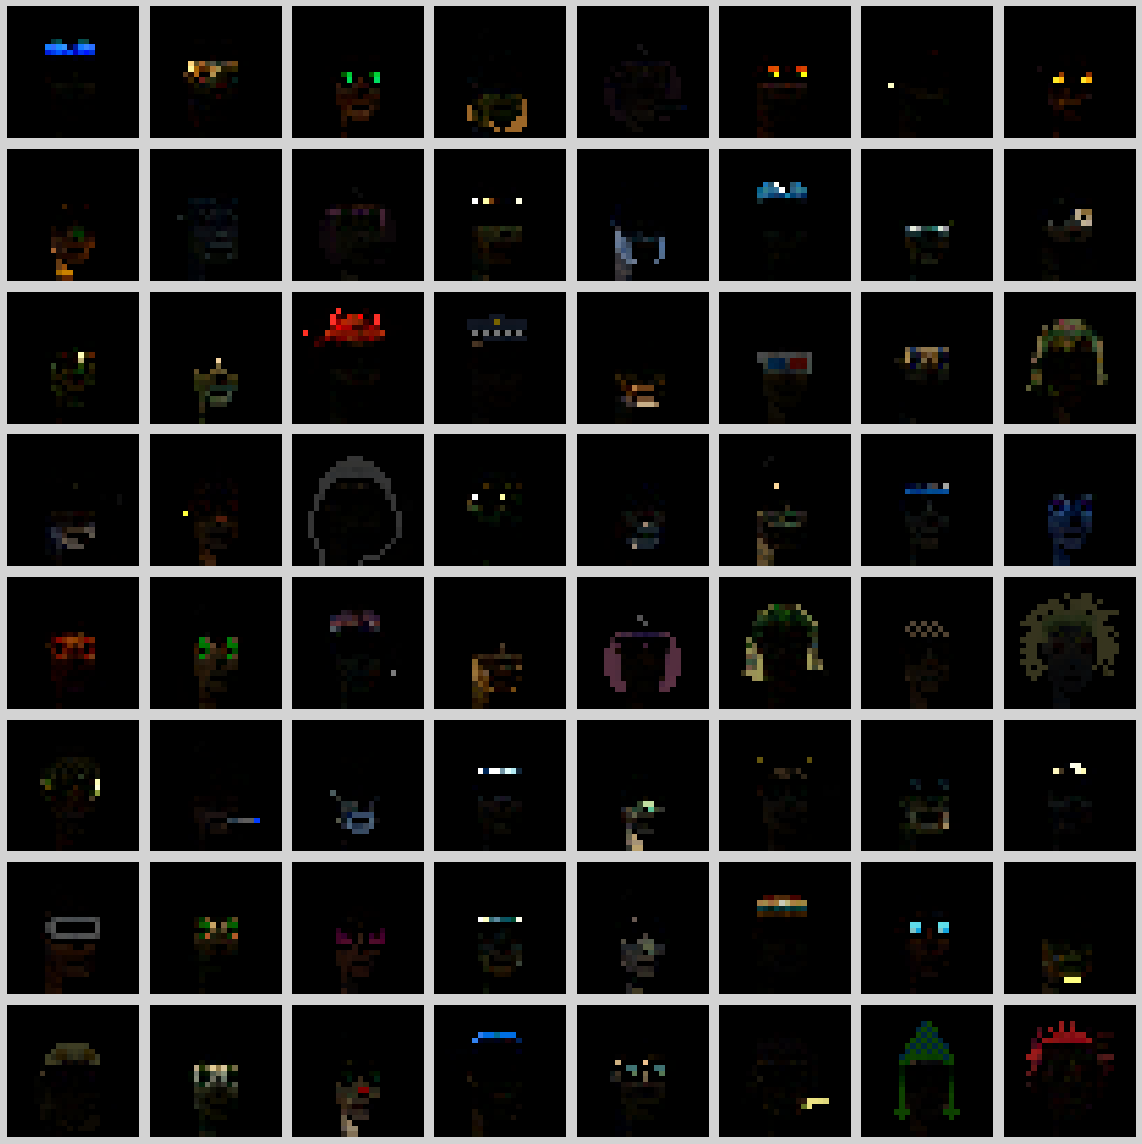

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

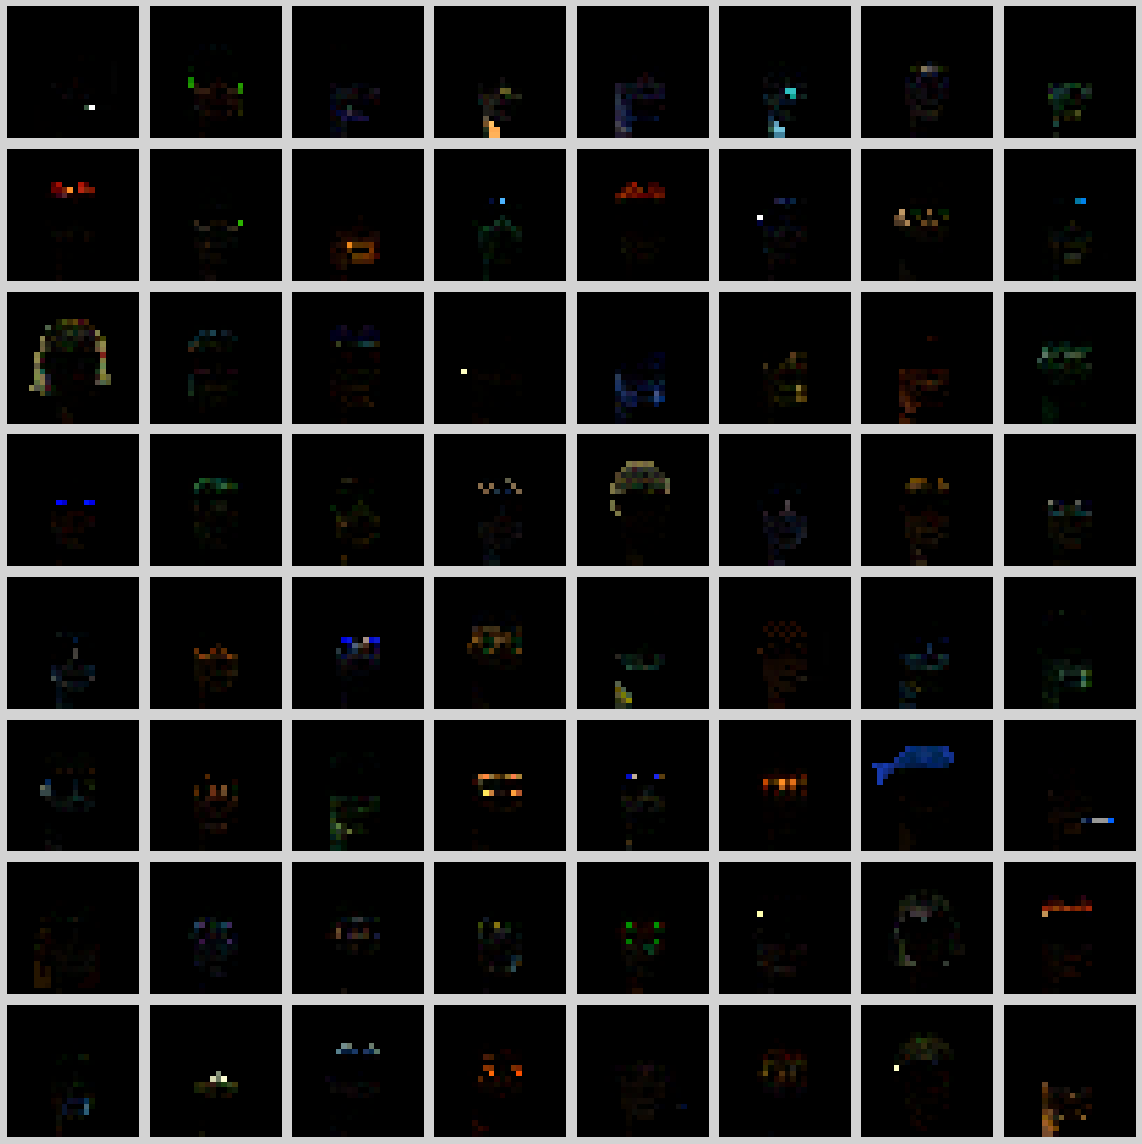

In [ ]:

plotimgs(W_reshaped, 8, filename="W_Matrix_Columns.png")
plotimgs(W2_reshaped, 8, filename="W_Matrix_Columns_2.png")
plotimgs(W3_reshaped, 8, filename="W_Matrix_Columns_3.png")





#2c

Essensialy what se see here is a compacted representation of common structures in the original "faces" datastructure. From the resulting plot, it looks like the W-matrix captures the different accesseries that the figures wear. We can see som images of hats, glasses and hairstyles. If we draw a paralell to the movie-example in the assignment sheet, here, instead of liking or not liking a genre of movies, it is more like having or not having a specific accessory. In the calculation using d = 64 we get 64 "categories" and the recurring traits get put into these. Since there columns of W represent features, when we multiply back with H we essentialy apply these features or accessories back onto a "user" to continue with the movie-genre analogy. Thus the W vector contains the features of the different images, and H how to combine and apply them. 


In the second plot the value of d is increased threefold to d = 192, and the third d = 500. Essentialy what we do here is adding more categories. With more categories the single trait being reprecented is more specific, and it is important to remember that in the second plot we only see 64 out of the 192 traits we have generated. What we took from this is essentially that d, the number of columns in W, corresponds to the amount of different categories in our representations. What value of d yields the best reconstruction we do not know, but we will try to find out later! 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

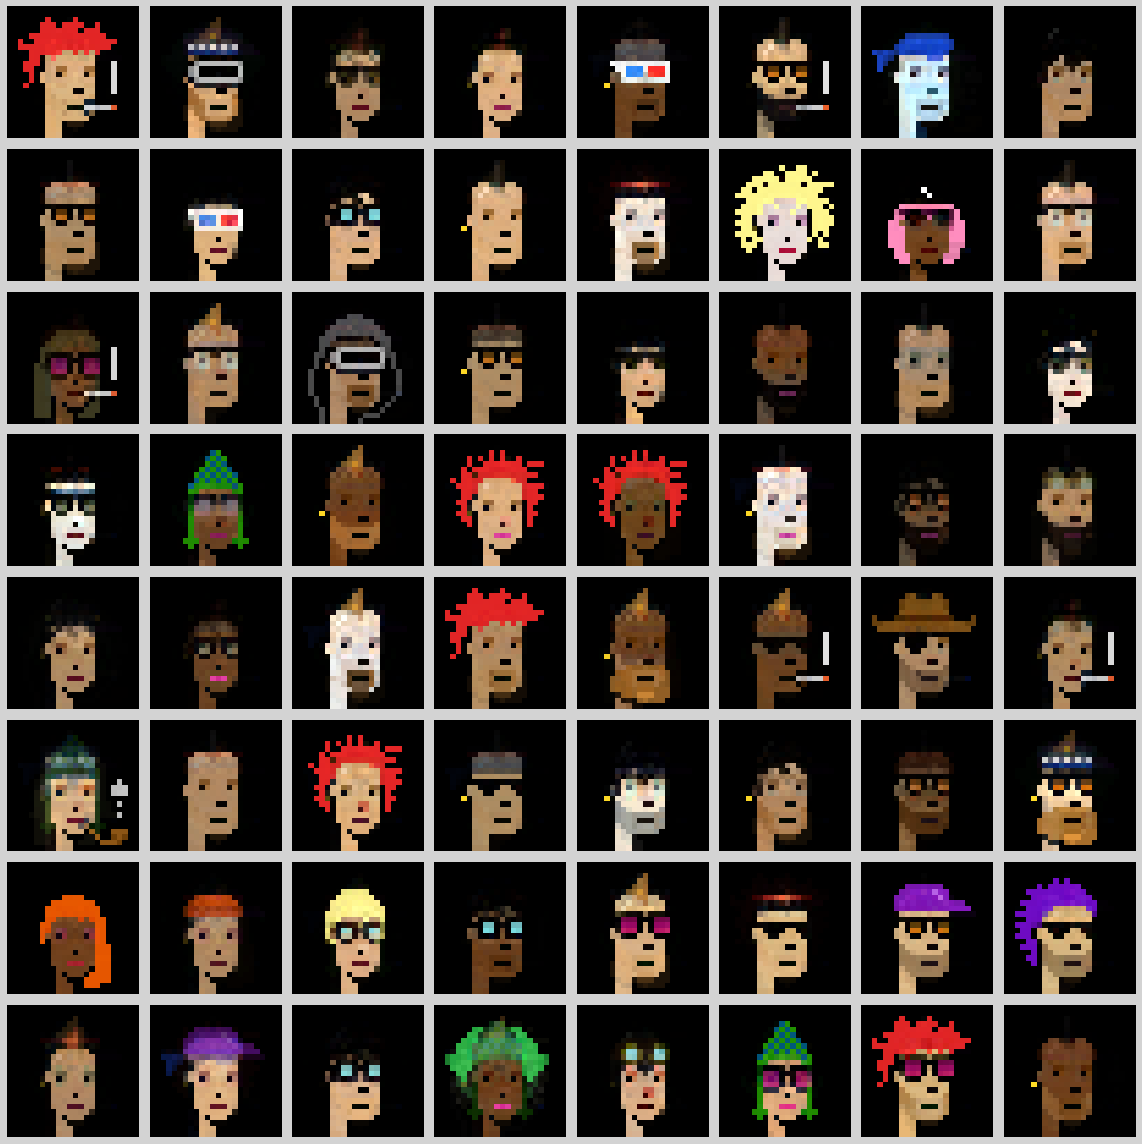

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

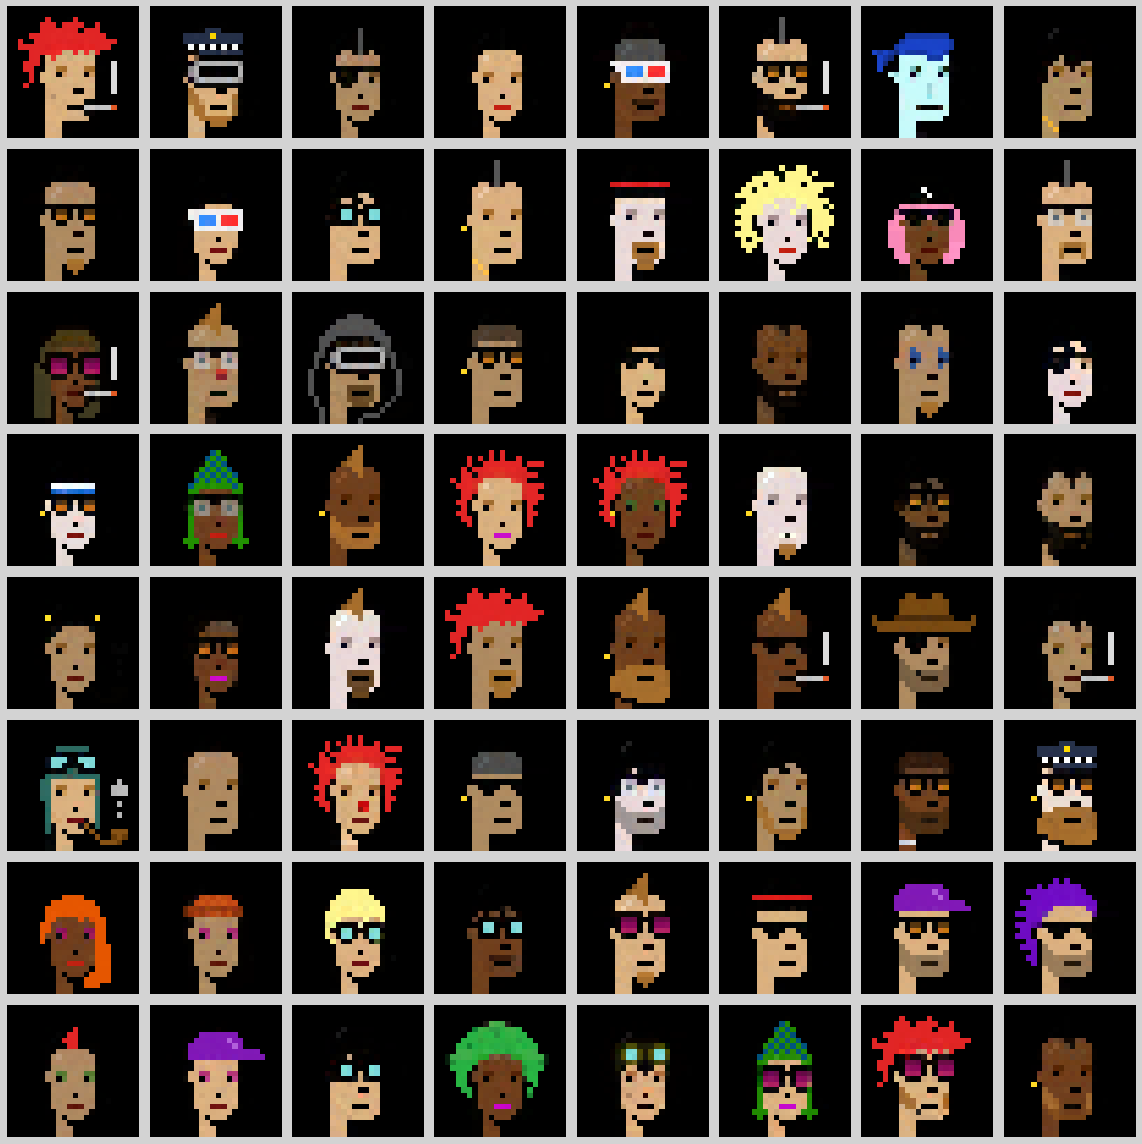

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

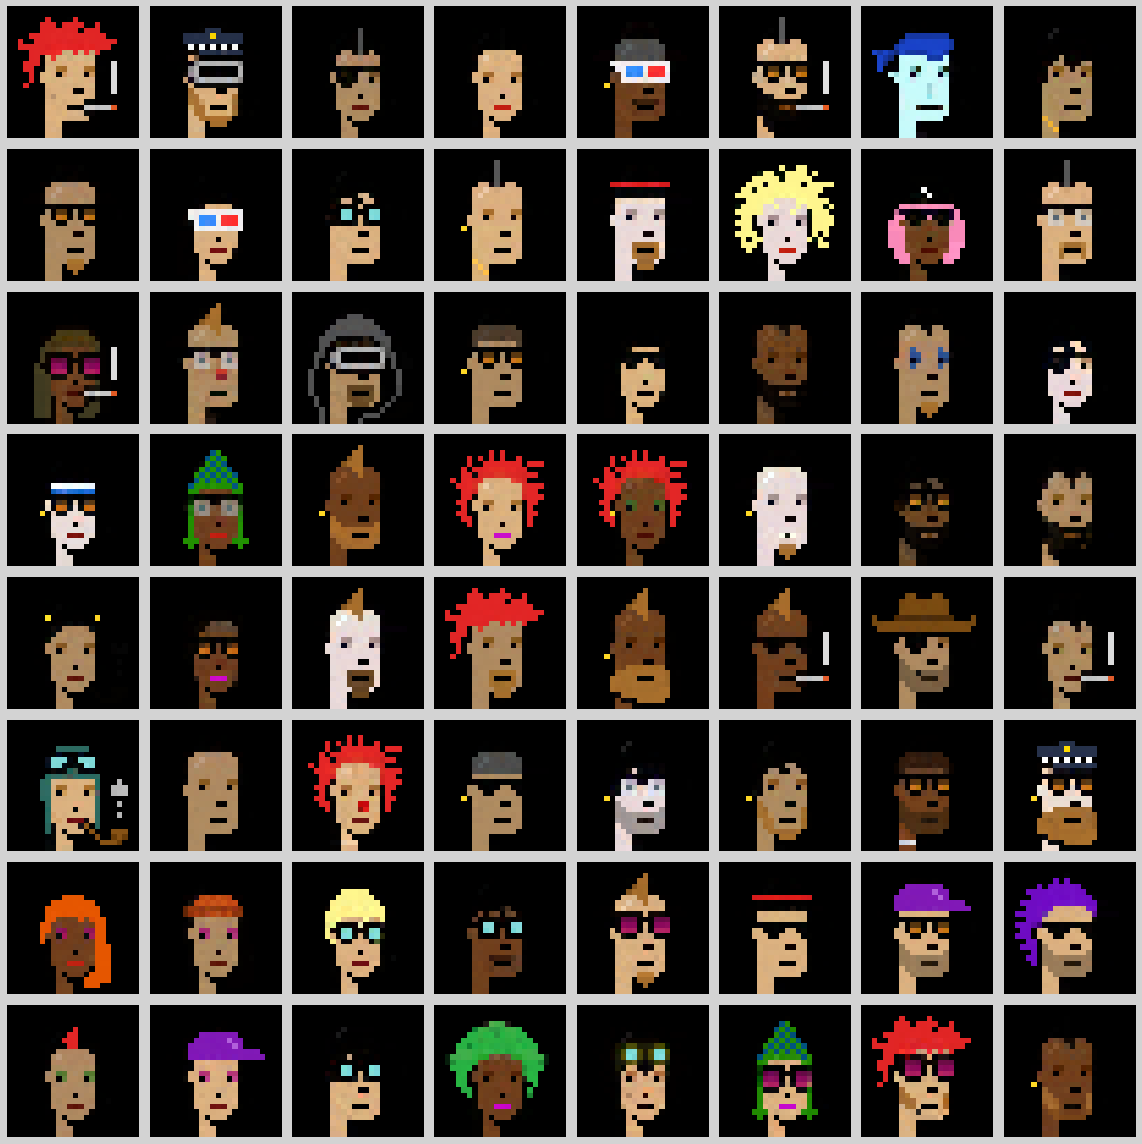

In [ ]:
#2d

faces_reconstructed = x[2]
faces_reconstructed_2 = x_2[2]
faces_reconstructed_3 = x_3[2]


faces_reconstructed_reshaped = faces_reconstructed.reshape(24,24,3,500)
faces_reconstructed_reshaped_2 = faces_reconstructed_2.reshape(24,24,3,500)
faces_reconstructed_reshaped_3 = faces_reconstructed_3.reshape(24,24,3,500)



plotimgs(faces_reconstructed_reshaped, 8, filename="punks_reshaped.png")
plotimgs(faces_reconstructed_reshaped_2, 8, filename="punks_reshaped_2.png")
plotimgs(faces_reconstructed_reshaped_2, 8, filename="punks_reshaped_3.png")




#2d

Above we have reconstructed the original faces array from it's factorizations. The reconstructions appears to be very similar visualy. However, as we ignored the opacity channel the background is not only represented by RGB values (0,0,0). This can make images of faces with dark or black features in the perimiter of the caracter more difficoult to spot, or impossible to distinguish. Other than that the images are fairly accurate. On the images we compared thoroughly the main difference appears to be in the detale of the skin. Where as the original images had figures with even skintone the reconstruction has notably nore "disturbance" and unregularities. Solid areas of color are not perfectly preserved, however hard borders, like the border bewteen figure and background appears to be very well preserved, even for d = 64. Even the more "crazy" and detaled hairstyles are pixel to pixel correct in general colour and position. Details surrounded by areas of the same color are sometimes faded, especially for d = 64. And it looks like smaller details that is not located where the face meets the background may entirely disapear for d = 64, so the choise of d is clearly of importance.

In [ ]:
#2e) 
np.random.seed(0)

d = 16
x16 = NMF(faces_reshaped, d, div_const, tol)
norm_arr16 = x16[3]
d = 32
x32 = NMF(faces_reshaped, d, div_const, tol)
norm_arr32 = x32[3]
#x: retun fra d = 64
norm_arr64 = x[3]


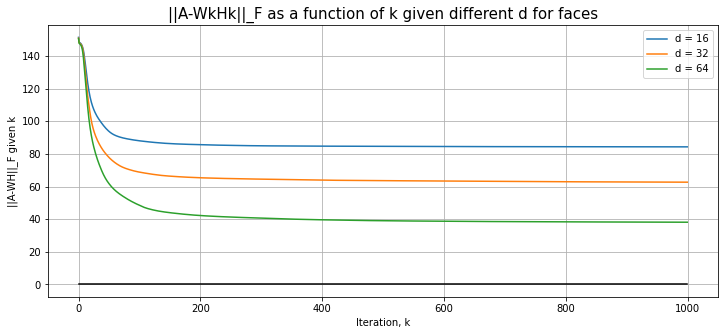

In [ ]:
#Creating an array containing the iterations: 
k = np.zeros(len(norm_arr16))
for i, value in enumerate(norm_arr16):
    k[i] = i

plt.figure(figsize=(12,5))
plt.title("||A-WkHk||_F as a function of k given different d for faces", size = 15)
plt.xlabel("Iteration, k")
plt.ylabel("||A-WH||_F given k")
plt.plot(k,np.zeros(len(k)), color="black")
plt.plot(k, norm_arr16, label = "d = 16")
plt.plot(k, norm_arr32, label = "d = 32")
plt.plot(k, norm_arr64, label = "d = 64")
plt.legend()
plt.grid()

The plots here are smiliar are reasonable in the sence that the Frobanius norm converges to a lower value given a higher $d$. As mentioned,a higher $d$ uses more data, and makes it posible to make a more exact factorization. From the looks of the plot it seems that the algorith has converged at around 600 iterations. 1000 iterations will therefor be considered enough in the next calculations. 

In [ ]:
#2f) 

#Using norm_arr16 and norm_arr64 from previous assignment
d = 128
x128 = NMF(faces_reshaped, d, div_const, tol)
norm_arr128 = x128[3]
d = 256
x256 = NMF(faces_reshaped, d, div_const, tol)
norm_arr256 = x256[3]

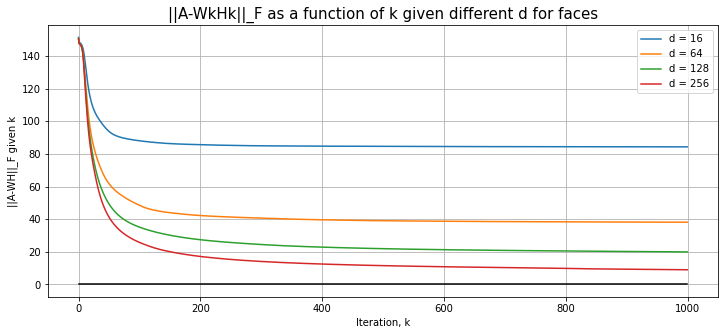

In [ ]:
plt.figure(figsize=(12,5))
plt.title("||A-WkHk||_F as a function of k given different d for faces", size = 15)
plt.xlabel("Iteration, k")
plt.ylabel("||A-WH||_F given k")
plt.plot(k,np.zeros(len(k)), color="black")
plt.plot(k, norm_arr16, label = "d = 16")
plt.plot(k, norm_arr64, label = "d = 64")
plt.plot(k, norm_arr128, label = "d = 128")
plt.plot(k, norm_arr256, label = "d = 256")
plt.legend()
plt.grid()

As seen in the plots before, the error converges closer to zero as $d$ gets higher. The patterns are better described and represented with a higher dimention. There is more room for the algorithm to spesify a certain trait. If $d$ gets high enough we would be able to represent each indicidual pixel as a trait, an therefor get that $A_{NMF} = A$. Since we have no noise, the patterns collected by the algorithm and represented by $W$ and $H$ can only get better since the algorithm will not pick up any unwanted patterns. 

In [ ]:
#3a

def add_noise(imgs_reshaped, sigma = 0.1):
    """
    Adds gaussian noise to images as described in text.
    Note that imgs must be given as a (24*24*3, N) numpy array, i.e the reshaped images
    Input:
        imgs_reshaped: (1728,N) numpy array
        sigma: scalar, noise level
    Output:
        noisy_faces: (1728,N) numpy array containing noisy images
    """
    # Noise level
    sigma = 0.1

    # Array that will store the rgb channels of the noisy images
    noisy_faces = np.copy(imgs_reshaped)

    # Number of noisy values we need
    nnzero = faces_reshaped[np.nonzero(imgs_reshaped)].shape[0]

    # Sample noisy values and add noise
    noise = np.random.normal(0.0,1,nnzero)
    noisy_faces[np.nonzero(imgs_reshaped)] += sigma*noise

    # Clip to lie between 0 and 1 so that we can still interpret them as images
    noisy_faces = np.maximum(0.0,np.minimum(1.0, noisy_faces))

    return noisy_faces


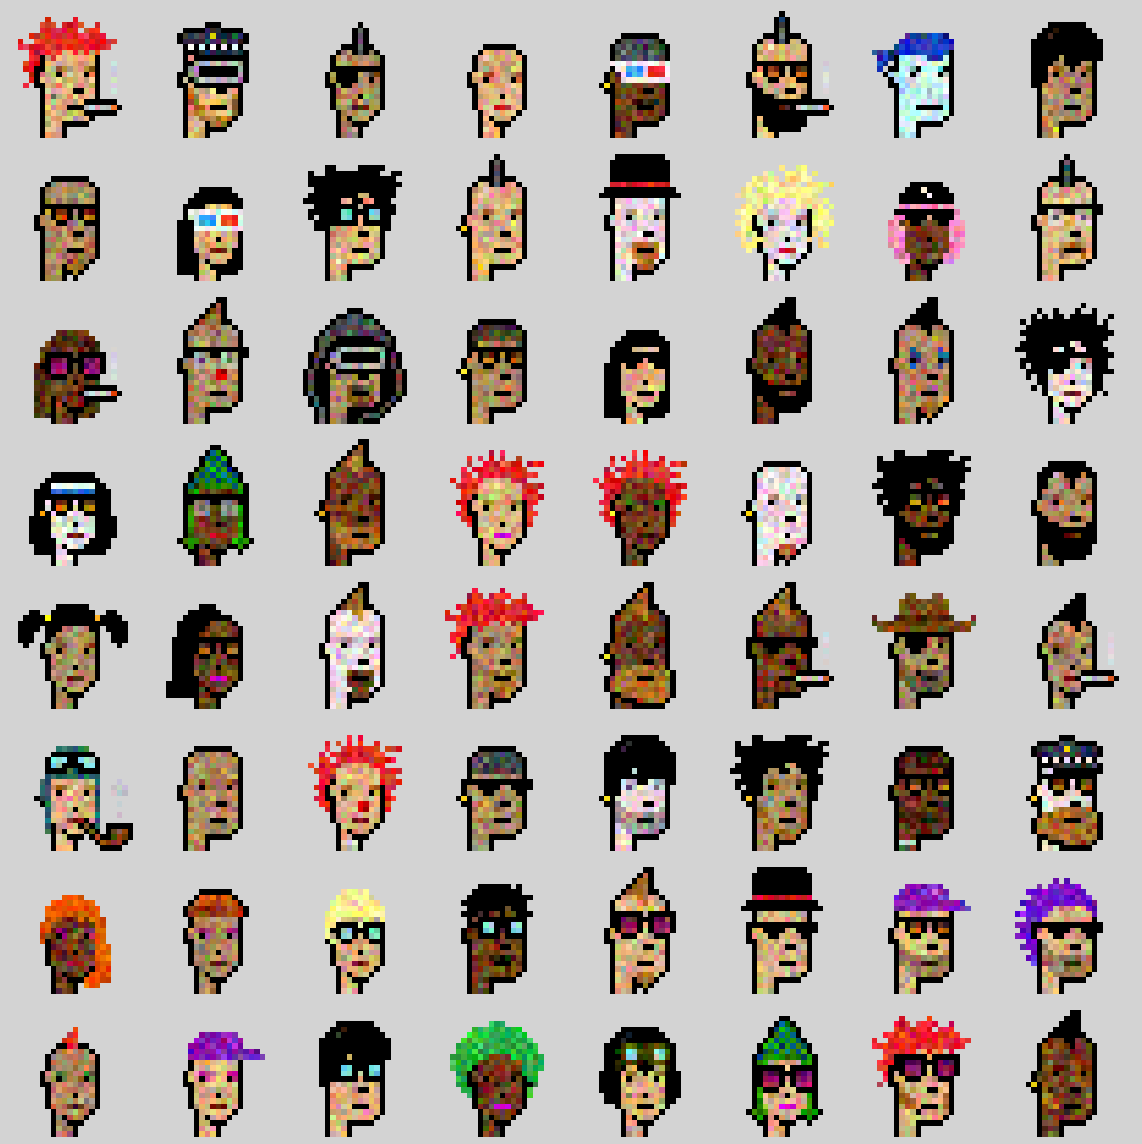

In [ ]:
#3a
faces_opacity = faces[:,:,3,:]

noisy_faces = add_noise(faces_reshaped)



# For plotting noisy images we add the opacity
noisy_faces_with_opacity = np.zeros(faces.shape)
noisy_faces_with_opacity[:,:,:3,:] = noisy_faces.reshape(faces_rgb.shape)
noisy_faces_with_opacity[:,:,3,:] = faces_opacity

plotimgs(noisy_faces_with_opacity, filename="noisy_punks.png")

In [ ]:
#3a Calculating the differance between A and A_noice in the F-norm taken from the supplied code

# Calculate the error of the noisy images
noise_residual = np.linalg.norm(noisy_faces - faces_reshaped, 'fro')
print(noise_residual)

42.48329471854096


In the code blocks above, i have ran the supplied code for making the images noisy, and calculated the differance between the original faces and the noisy ones in the F-norm. 

3b)

Now, we will run the factorization code for the noisy faces, from this we extract the matrix $W$ and the reconstruction. Then we plot these datasets with the supplied code.

In [ ]:
#3b
d = 64
x_noisy = NMF(noisy_faces, d, div_const, tol)



In [ ]:
d = 64
noisy_faces_W = x_noisy[0].reshape(24,24,3,64)
noisy_faces_reconstruction = x_noisy[2]
noisy_faces_reconstruction_reshaped = x_noisy[2].reshape(24,24,3,500)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

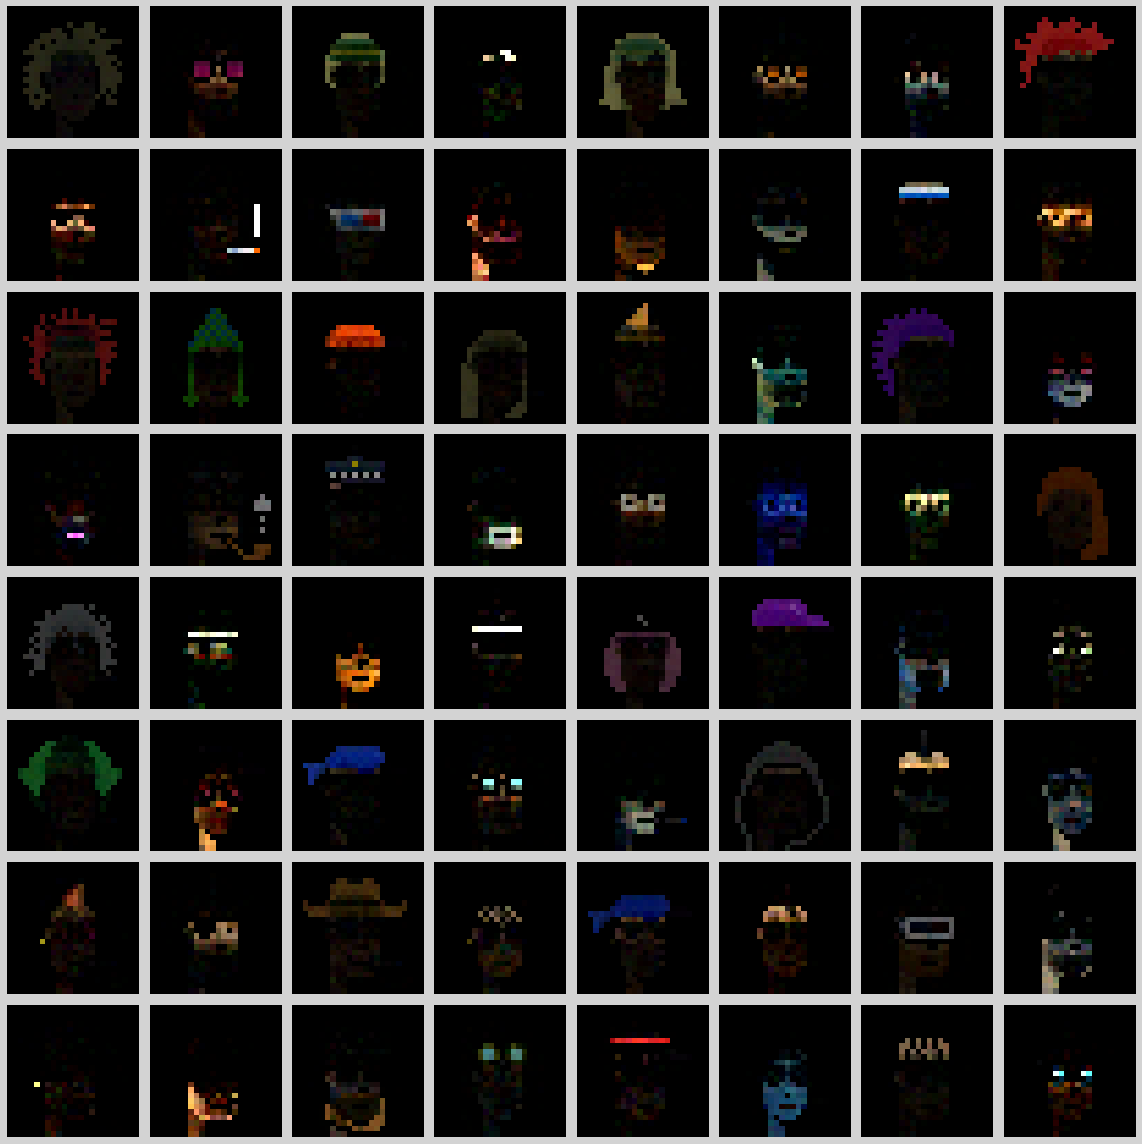

In [ ]:
plotimgs(noisy_faces_W, 8, filename="W_Matrix_Columns_noisy.png")


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

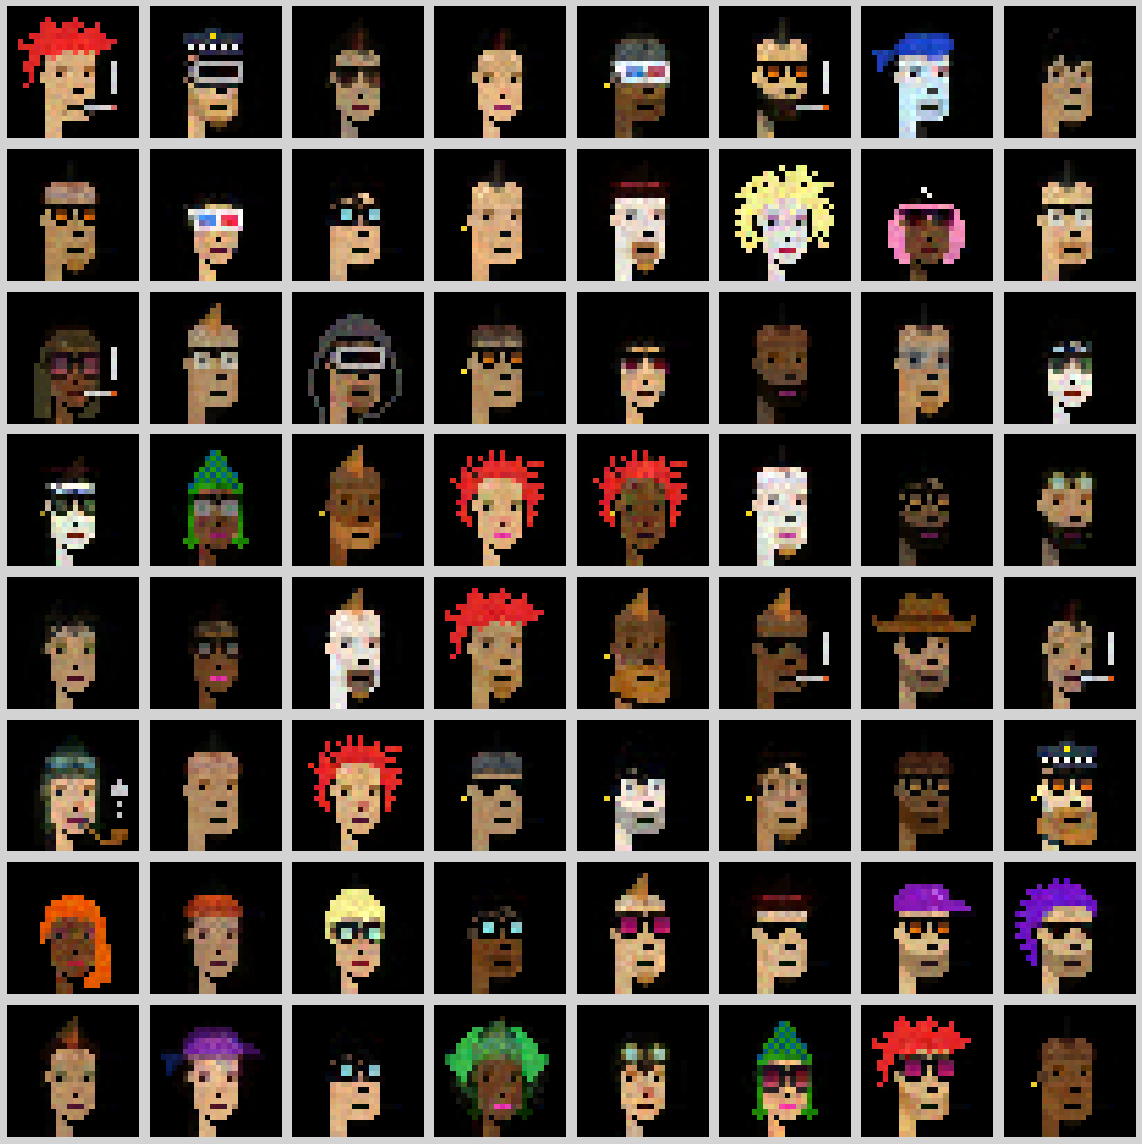

In [ ]:
d = 64

plotimgs(noisy_faces_reconstruction_reshaped, 8, filename="noisy_punks_reshaped.png")




3b)

The last plot above show the reconstructed dataset from the factorization done on the noisy images. As we see, much of the noise is gone! It is still considerable different from the original, and it is more noisy than the reconstructions of the original. The columns of W as we see in the first plot looks quite similar to the ones from task 2. However it looks like the traits are slightly affected by the noice, but not so significately. The columns of the W matrix corresponding to the non-noisy images with d = 64 seem to capture more of the facial features, such as face shape or skin color, around things like hair and glasses.  



How can we achieve the optimal denoising, will a larger $d$ allways give a smaller error? In the codeblock underneath the optimal dimension $d$ is found by analysing a plot giving the error as a function of $d$.

In [ ]:
#3c) 
#Calculating ||A-WH||_F as a function of d


#For noisy faces:
d_range = 5
#d_arr_noise = np.around(np.linspace(16,1000, d_range))
d_arr_noise = np.array([16,64,256,393,500,700])
norm_arr_noise = np.zeros(len(d_arr_noise))


for i,d in enumerate(d_arr_noise): 
    x = NMF(noisy_faces, int(d), div_const, tol)
    norm = np.linalg.norm(faces_rgb.reshape(1728,500)-x[2], 'fro')
    norm_arr_noise[i] = norm
    


In [ ]:
#For not noisy faces:

d_range = 5
d_arr = d_arr_noise
norm_arr = np.zeros(len(d_arr))


for i,d in enumerate(d_arr): 
    x = NMF(faces_reshaped, int(d), div_const, tol)
    norm = np.linalg.norm(faces_rgb.reshape(1728,500)-x[2], 'fro')
    norm_arr[i] = norm


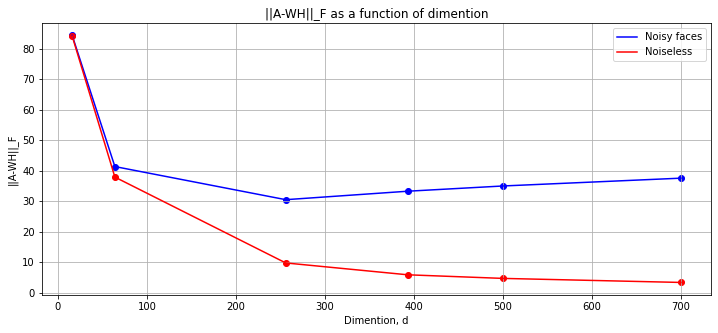

In [ ]:

plt.figure(figsize=(12,5))
plt.title("||A-WH||_F as a function of dimention")
plt.xlabel("Dimention, d")
plt.ylabel("||A-WH||_F")
plt.plot(d_arr_noise,norm_arr_noise, label = "Noisy faces", color = "blue")
plt.scatter(d_arr_noise, norm_arr_noise, color = "blue")
plt.plot(d_arr, norm_arr, label = "Noiseless", color = "red")
plt.scatter(d_arr, norm_arr, color = "red")
plt.legend(loc = "upper right")
plt.grid()
    

Due to the long running time of the factorization calculation for large values for $d$, the datapoints in the plot are limited. Observing the figure above gives us an indication of the smallest $d$ is nessecery to get an appropriate amount of error. The error is here refered to as $||A-WH||_F$. From the datapoints chosen there is an overfitting for $d>256$, and an underfitting for $d < 256$ for the noisy faces. For $d>256$ we are working with large matrixes that contains more parameters that can be justified by the data. The variation is then axtracted as if it represents an underlying model structure. This is not a fenomenon observed for the noiseless faces, as this variation does not exist and unwanted patterns are not picked up on. 

For the underfitted factorizations  the dimention is too small to represent the underlying structure in the origingal data, and will give us a larger error. This fenomenon is observed for both the noiseless and noisy faces. Due to the limitations of datapoints in our plot, the conclusion of which $d$ gives the best fit is only an approximation. Still it is observes that the best fit lies around $d=256$. This implies that the omount of distinct features can be represented with $d=256$, before the algorithm finds patterns in the noise. Having less noise would then probably have shifted the minimum to the right. 

From the movie example on page 4 in the assignment, $d=2$ is adequate to represent the pattern desiered. Any larger $d$ would simply make the data harder to read and represent. The same fenomenon is relevent to Punk Faces. Even though there are 6 movies, these can be compressed into two categories, where we see patterns in the users. In the same way, it looks like there are approximately $256$ different features making up all the faces using linear combinations. 
 

##### Conclusion

So, what have we learned from all this? Well fist of all, the notion of factorizing matrices, and having a numerical method for doing so is powerfull in and of itself. The methods, like fixed point iteration, builds on subjects that are known to us from other less practical courses, so it is exciting to see it work in a practical situation. The NMF method proved to have the pitfalls that we were warned against in this, as well as other, courses. Local minimums can throw us off the true solution we are looking for by the contraction working against us in the fixed point iteraton as seen in task 1c. This is food for thought when setting up the code and the method in general. In the case of NMF an all-zero initialization leading to a false solution makes sense, as we only handle positive values, and the criterium for a good solution is the norm value of the difference between the original matrix and it's factorization. In other similar methods we might have to think more thoroughly when choosing initializations. 

When a good factorization has been found, we found that the W matrix in particular contained impressively usefull and accurate descriptions of the elements in the data set. Although it is not perfect, in a context such as this one with the images, it does preserve a visually adequate representation of the different featues in the dataset. And the reconstruction of the matrix A; WH also gives us a very convincing representation of the original data. In cases where the accuracy of the reconstruction is paramount, a method such as NMF should perhaps be changed to a more precice one, or choose a value for d that makes the factorization as accurate as possible. In situations such as this however, it proved to be a decent tool for dimention reduction. The idea of dimention reduction is very interesting in the context of data storage space. The fact that we can "compress" the data into a smaller space, and then unpack it in a procedurally oriented space seems very powerfull. Images are very storage heavy datastructures, and having a tool to reduce the space they is certainly useful. There is, however, a backside to the compression. And that is loss of accuracy. Exsamples of this is common when sharing images online. If you share a high resolution image over Messenger, as an exsample, the image will be heavily reduced in complecity/resolution. (If it is small enough to be sent at all), however, if it is sent by email, there is no reduciton. (or less so) But when facing constraints on the capacity of data transfer, dimention reduction methods can be very usefull! Also, in processes that rely on real-time packet processing, a dimentionality reduction can also limit the number of packets being sent, recieved and processes, thus reducing potential losses.

The NMF method proved effective en removing noise from the images. Although not perfect, the reconstruction of the noisy images were considerably less noisy than the original. The fact that this works as well as it does, means that the NMF is a usefull tool for denoising. However, when hadeling datasets that are "noisy" in nature, the NFM may have the opposite effect of what we want. When handling very detailed images, that consists of many colors and, no clear cohetsion or large structures, methods such as the NMF do a poor job. A great example of an effect such as this is the video compression algoritm that Youtube uses. In a great video to showcase this was put put by the channel "The Slow Mo Guys". In the video they dropped a bunch of glitter, and filmed it with a highspeed camera. (https://youtu.be/BtYKDamqo2I) On their end the resulting video captured all the glitter particles, and probably looked really cool, and probably used hundreds of gigabytes. However, as they explain, when uploading to a platform like Youtube, it is not feasible to display videos with such detail. Therefore it is compressed using an algorithm. In this case, the motive that they wanted to capture is very noisy in nature. This leads to the compression algorithm working against the creators, and completely ruining the video. So there are clear downsides to the noise reducing nature of methods such as the NMF.




 




<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7a25c552-0f8e-468e-921c-7baa56fade21' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>